# Lending Club Loan Data Modeling

In this section we will attempt to determine the best model to predict whether or not a borrower will default in the Lending Club Loan data.

We will start with a **_Logistic Regresion_** model, using **_Forward Selection_** to determine the features. We will then try a **_Support Vector Machine_**, **_Decision Tree_** and **_Random Forest_**. 

After we'll wrap it all up with a summary of what we have learned.

First, let's import a butt load of packages per usual!

In [37]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

# Cleaning

In [3]:
def features_from_excel():
    lc_dd = pd.read_excel(r'data/LCDataDictionary.xlsx')
    qstr = 'Include == 1'
    cols = [x.strip() for x in lc_dd.query(qstr).LoanStatNew.values.tolist()]
    cols.remove('id')
    return cols

def loan_status_filter(input_df):
    df = input_df.copy()
    loan_status_lst = ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Default']
    mask = df.loan_status.isin(loan_status_lst)
    return df.loc[mask, :]

def make_dummy(input_df, column):
    df = input_df.copy()
    dummies = (df.loc[:, [column]]
               .pipe(pd.get_dummies))
    return df.join(dummies).drop(column, axis=1)

def mcnulty_preprocessing():
    print('Initiating MAXIMUM data munging power')
    df = (pd.read_csv(r'Data/loan.csv', low_memory=False)
          .set_index('id')
          .pipe(loan_status_filter)
          .query('application_type == "INDIVIDUAL"')
          .query('home_ownership != "ANY"')
          .loc[:, features_from_excel()]
          .assign(issue_d=lambda x: x.issue_d.astype('datetime64'),
                  default=lambda x: np.where(x.loan_status=='Fully Paid', 0, 1),
                  term=lambda x: x.term.str.strip(),
                  emp_length=lambda x: x.emp_length.fillna('Not provided')))
    print('Luther Preprocessing Successful Woo Woo!\n')
    return df

In [4]:
df = mcnulty_preprocessing()

Initiating MAXIMUM data munging power
Luther Preprocessing Successful Woo Woo!



# Single Feature Logistic Regressions

In [4]:
independents = [
    ['dti'],
    ['int_rate'],
    ['annual_inc'],
    ['loan_amnt'],
    ['revol_bal'],
    ['term'],
    ['delinq_2yrs'],
    ['home_ownership'],
    ['grade'],
    ['purpose'],
    ['emp_length']]
dependent = 'default'

In [11]:
def results_to_df(results):
    col_ord = ['model_type', 'features', 'degree', 
               'train_accuracy', 'test_accuracy', 'precision', 'recall', 'f1_score', 
               'true_negatives', 'false_positives', 'false_negatives', 'true_positives'] 
    return (pd.DataFrame(results)
            .reindex(columns=col_ord)
            .sort_values('test_accuracy', ascending=False))

def scores_formatted(input_df):
    df = input_df.copy()
    scores = ['train_accuracy', 'test_accuracy', 'precision', 'recall', 'f1_score']
    for s in scores:
        df[s] = df[s].map('{:0.2%}'.format)
    gross_scores = ['true_negatives', 'false_positives', 'false_negatives', 'true_positives']
    for gs in gross_scores:
        df[gs] = df[gs].map('{:,.0f}'.format)
    return df
    
def log_clf_model(results, model, model_type, X, y, features, degree=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,
                                                        stratify=y)
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    y_hat = model.predict(X_test)
    precision = metrics.precision_score(y_test, y_hat)
    recall = metrics.recall_score(y_test, y_hat)
    f1 = metrics.f1_score(y_test, y_hat)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_hat).ravel()
    record = {'model_type': model_type,
              'features': features,
              'degree': degree,
              'train_accuracy': train_accuracy,
              'test_accuracy': test_accuracy,
              'precision': precision,
              'recall': recall,
              'f1_score': f1,
              'true_negatives': tn,
              'false_positives': fp,
              'false_negatives': fn,
              'true_positives': tp}
    results.append(record)

In [6]:
results = list()
for variable in independents:
    X, y = df.loc[:, variable], df.loc[:, dependent]
    clf = LogisticRegression(solver='lbfgs')
    if X.iloc[:, 0].dtype not in [np.float64, np.int64]:
        enc = OneHotEncoder()
        X = enc.fit_transform(X)
        log_clf_model(results, clf, 'Logistic Regression', X, y, variable)
    else:
        for degree in range(1, 4):
            if degree == 1:
                clf = LogisticRegression(solver='lbfgs')
                log_clf_model(results, clf, 'Logistic Regression', X, y, variable)
            else:
                clf = Pipeline([('poly', PolynomialFeatures(degree)), 
                                ('clf', LogisticRegression(solver='lbfgs'))])
                log_clf_model(results, clf, 'Logistic Regression', X, y, variable, degree)
# Let's also add a bias model
X = np.ones((df.shape[0], 1))
y = df.loc[:, dependent]
clf = LogisticRegression(solver='lbfgs')
log_clf_model(results, clf, 'Logistic Regression', X, y, 'bias')
(results_to_df(results)
 .pipe(scores_formatted))

,model_type,features,degree,train_accuracy,test_accuracy,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives
4,Logistic Regression,[int_rate],2,78.16%,78.16%,55.56%,0.04%,0.09%,"41,541",4,"11,606",5
0,Logistic Regression,[dti],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
1,Logistic Regression,[dti],2,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
22,Logistic Regression,[emp_length],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
21,Logistic Regression,[purpose],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
20,Logistic Regression,[grade],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
19,Logistic Regression,[home_ownership],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
18,Logistic Regression,[delinq_2yrs],3,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
17,Logistic Regression,[delinq_2yrs],2,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
15,Logistic Regression,[term],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0


We can see that all our models except 2 are guess 100 percent non-default. This is common with imbalanced classes. We are basically dealing with a high-bias problem here. We need to add features to **_reduce bias_** and **_add variance_**.

We'll start slow by adding only one additional feature.

# Logistic Regression with Two Features and Polynomials

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

def unpack_list(lst_2d):
    return list(itertools.chain.from_iterable(lst_2d))

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict.loc[:, self.key]
    
def poly_pipeline(features, degree):
    poly_steps = [('selector', ItemSelector(key=features)),
                  ('poly', PolynomialFeatures(degree=degree, include_bias=False))]
    pipeline = Pipeline(poly_steps)
    return pipeline

def dummy_pipeline(feature_name):
    feature = [feature_name]
    steps = [('selector', ItemSelector(key=feature)),
             ('enc', OneHotEncoder())]
    pipeline = Pipeline(steps)
    return pipeline

def feature_transformer_list(features, degree):
    transformer_list = list()
    numerics = [x for x in features if independents[x] == 'numeric']
    if numerics:
        numeric_trans = ('numeric', poly_pipeline(numerics, degree))
        transformer_list.append(numeric_trans)
    dummy_vars = [x for x in features if independents[x] == 'dummy']
    if dummy_vars:
        dummy_steps = list()
        for dummy in dummy_vars:
            step = ('{}_enc'.format(dummy), dummy_pipeline(dummy))
            dummy_steps.append(step)
        transformer_list += dummy_steps
    return transformer_list

def clf_pipeline(clf, features, degree):
    transformer_list = feature_transformer_list(features, degree)
    return Pipeline([('union', FeatureUnion(transformer_list=transformer_list)),
                     ('clf', clf)])

In [42]:
independents = {'dti': 'numeric',
                'int_rate': 'numeric',
                'annual_inc': 'numeric',
                'loan_amnt': 'numeric',
                'revol_bal': 'numeric',
                'installment': 'numeric',
                'delinq_2yrs': 'numeric',
                'term': 'dummy',
                'home_ownership': 'dummy',
                'grade': 'dummy',
                'purpose': 'dummy',
                'emp_length': 'dummy',
                'addr_state': 'dummy'}
dependent = 'default'

In [8]:
results = list()
for features_tuple in itertools.combinations(list(independents.keys()), 2):
    features = list(features_tuple)
    if independents[features[0]] == 'dummy' and independents[features[1]] == 'dummy':
        clf = LogisticRegression(solver='lbfgs')
        pipeline = clf_pipeline(clf, features, degree)
        log_clf_model(results, pipeline, 'Logistic Regression', df, y, features, 1)
    else: 
        for degree in range(1, 4):
            clf = LogisticRegression(solver='lbfgs')
            pipeline = clf_pipeline(clf, features, degree)
            log_clf_model(results, pipeline, 'Logistic Regression', df, y, features, degree)
# Let's also add a bias model
X = np.ones((df.shape[0], 1))
y = df.loc[:, dependent]
clf = LogisticRegression(solver='lbfgs')
log_clf_model(results, clf, 'Logistic Regression', X, y, 'bias')
(results_to_df(results)
 .pipe(scores_formatted)
 .head(10))

NameError: name 'itertools' is not defined

In [ ]:
for features_tuple in itertools.combinations(list(independents.keys()), 3):
    features = list(features_tuple)
    if (    independents[features[0]] == 'dummy'
        and independents[features[1]] == 'dummy'
        and independents[features[2]] == 'dummy'):
        clf = LogisticRegression(solver='lbfgs')
        pipeline = clf_pipeline(clf, features, degree)
        log_clf_model(results, pipeline, 'Logistic Regression', df, y, features, 1)
    else: 
        for degree in range(1, 4):
            clf = LogisticRegression(solver='lbfgs')
            pipeline = clf_pipeline(clf, features, degree)
            log_clf_model(results, pipeline, 'Logistic Regression', df, y, features, degree)
(results_to_df(results)
 .pipe(scores_formatted)
 .head(15))

In [ ]:
list(set(unpack_list(results_to_df(results)
         .pipe(scores_formatted)
         .head(15)
         .features.tolist())))

## Visualization of Best Model

In [10]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x*1e-6)
mil_fmt = FuncFormatter(millions)

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x*1e-3)
k_fmt = FuncFormatter(thousands)

def percent(x, pos):
    return '{:,.2%}'.format(x)
percent_formatter = FuncFormatter(percent)

In [16]:
def plot_estimator(estimator, X, y):
    x_min, x_max = X.iloc[:,0].min() - 0.1, X.iloc[:,0].max() + 0.1
    y_min, y_max = X.iloc[:,1].min() - 0.1, X.iloc[:,1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    df_linspace = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns.tolist())
    Z = estimator.predict(df_linspace)
                        
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(12,12))
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
    # Lets plot our sample points
    default_mask = y == 1
    ax.scatter(X.iloc[:, 0][~default_mask], X.iloc[:, 1][~default_mask], c='blue', label='Fully Paid',
              alpha=0.9, edgecolors='black')
    ax.scatter(X.iloc[:, 0][default_mask], X.iloc[:, 1][default_mask], c='red', label='Default',
              alpha=0.5, edgecolors='black')
    ax.set(xlabel='DTI', ylabel='Interest Rate')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.legend()

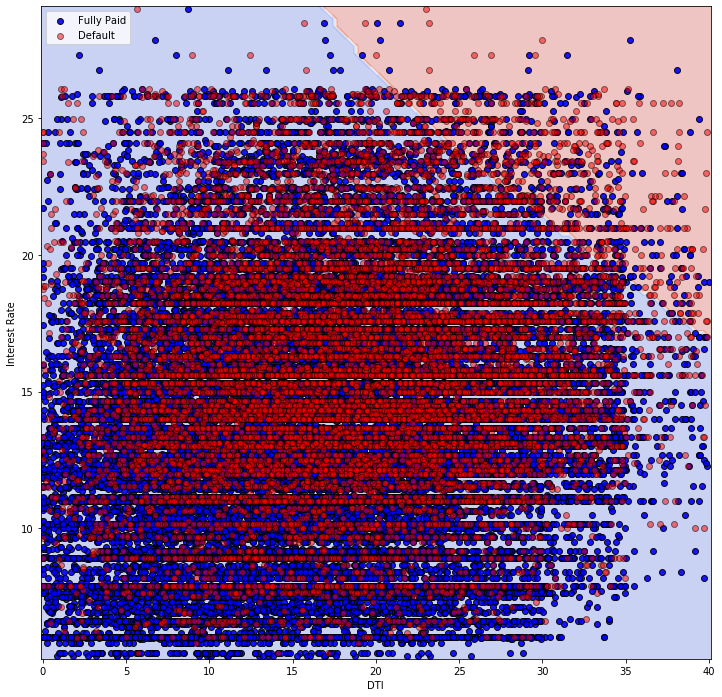

In [17]:
features = ['dti', 'int_rate']
X, y = df.loc[:, features], df.loc[:, dependent]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,
                                                    stratify=y)
degree = 2
clf = clf_pipeline(LogisticRegression(), features, degree)
clf.fit(X_train, y_train)
plot_estimator(clf, X_test,y_test)

It's not great, but our classifer is definitely telling us people with higher Debt-to-Income Ratios and higher Interest Rates are more likely to default, which makes sense. We can tell from this that the data doesn't provide us with a clean split unfortunately.

## Grid Search with Class Weights

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term']
degree = 2
X, y = df.loc[:, features], df.loc[:, dependent]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,
                                                    stratify=y)
pipeline = clf_pipeline(LogisticRegression(), features, degree)
weight_space = np.linspace(0.05, 0.95, 20)
class_weights = [{0: x, 1: 1.0-x} for x in weight_space]
hyperparameters = dict(clf__class_weight=class_weights)
gs = GridSearchCV(pipeline, hyperparameters, scoring='f1', cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         ItemSelector(key=['dti',
                                                                                                           'int_rate',
                                                                                                           'delinq_2yrs',
                                                                                                           'revol_bal',
                                   

In [22]:
print("Best Class Weights : {}".format(pd.DataFramegs.best_params_))

Best parameters : {'clf__class_weight': {0: 0.23947368421052628, 1: 0.7605263157894737}}


In [31]:
results = list()

In [32]:
#class_weight = gs.best_params_['clf__class_weight']
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term']
class_weight = {0: 0.23947368421052628, 1: 0.7605263157894737}
logr = LogisticRegression(class_weight=class_weight)
X, y = df.loc[:, features], df.loc[:, dependent]
pipeline = clf_pipeline(logr, features, degree)
log_clf_model(results, pipeline, 'Logistic Regression with Class Weights', X, y, features, degree=degree)

,model_type,features,degree,train_accuracy,test_accuracy,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives
0,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term]",3,35.91%,36.02%,22.38%,78.12%,34.79%,"10,079","31,466","2,541","9,070"


In [33]:
degree = 2
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term', 'installment']
class_weight = {0: 0.23947368421052628, 1: 0.7605263157894737}
logr = LogisticRegression(class_weight=class_weight)
X, y = df.loc[:, features], df.loc[:, dependent]
pipeline = clf_pipeline(logr, features, degree)
log_clf_model(results, pipeline, 'Logistic Regression with Class Weights', X, y, features, degree=degree)

In [34]:
degree = 3
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term', 'installment']
class_weight = {0: 0.23947368421052628, 1: 0.7605263157894737}
logr = LogisticRegression(class_weight=class_weight)
X, y = df.loc[:, features], df.loc[:, dependent]
pipeline = clf_pipeline(logr, features, degree)
log_clf_model(results, pipeline, 'Logistic Regression with Class Weights', X, y, features, degree=degree)

In [43]:
degree = 3
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term', 'installment',
            'addr_state']
class_weight = {0: 0.23947368421052628, 1: 0.7605263157894737}
logr = LogisticRegression(class_weight=class_weight)
X, y = df.loc[:, features], df.loc[:, dependent]
pipeline = clf_pipeline(logr, features, degree)
log_clf_model(results, pipeline, 'Logistic Regression with Class Weights', X, y, features, degree=degree)

In [44]:
(results_to_df(results)
 .pipe(scores_formatted)
 .head(10))

,model_type,features,degree,train_accuracy,test_accuracy,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives
0,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term]",3,35.91%,36.02%,22.38%,78.12%,34.79%,"10,079","31,466","2,541","9,070"
1,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",2,33.59%,33.98%,23.55%,90.02%,37.33%,"7,610","33,935","1,159","10,452"
2,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",3,31.37%,31.59%,22.87%,89.87%,36.47%,"6,359","35,186","1,176","10,435"
3,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",3,31.37%,31.59%,22.87%,89.87%,36.47%,"6,359","35,186","1,176","10,435"


## Random Forest

We did some great work with our logistic regression modeling, but let's see if we can obtain a little more accuracy with a random forest.

In [45]:
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term', 'installment', 'addr_state']
model_name = 'Random Forest'
X, y = df.loc[:, features], df.loc[:, dependent]
rf = RandomForestClassifier()
pipeline = clf_pipeline(rf, features, degree)
log_clf_model(results, pipeline, model_name, X, y, features, degree=1)

In [47]:
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term', 'installment', 'addr_state']
model_name = 'Random Forest with class weights'
X, y = df.loc[:, features], df.loc[:, dependent]
rf = RandomForestClassifier(class_weight='balanced')
pipeline = clf_pipeline(rf, features, degree)
log_clf_model(results, pipeline, model_name, X, y, features, degree=1)

In [48]:
(results_to_df(results)
 .pipe(scores_formatted)
 .head(10))

,model_type,features,degree,train_accuracy,test_accuracy,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives
5,Random Forest with class weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",1,97.60%,77.13%,41.58%,11.58%,18.12%,"39,655","1,890","10,266","1,345"
4,Random Forest,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",1,97.71%,76.86%,40.22%,12.23%,18.76%,"39,434","2,111","10,191","1,420"
0,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term]",3,35.91%,36.02%,22.38%,78.12%,34.79%,"10,079","31,466","2,541","9,070"
1,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",2,33.59%,33.98%,23.55%,90.02%,37.33%,"7,610","33,935","1,159","10,452"
2,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",3,31.37%,31.59%,22.87%,89.87%,36.47%,"6,359","35,186","1,176","10,435"
3,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",3,31.37%,31.59%,22.87%,89.87%,36.47%,"6,359","35,186","1,176","10,435"
